<a href="https://www.kaggle.com/code/stevenmpro/spaceship-titanic-improved?scriptVersionId=104741070" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

____________________________________

### This notebook is created to answer the competition and improve my knowledge on how kaggle works.

### In order to use all functions, this notebook is based on Arif Enes Aydın's.

Link : https://www.kaggle.com/code/arifenesaydn/spaceship-titanic

________

## 1. Importing the librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder,\
                                StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## 2. Importing the data:

In [2]:
# Listing directoriers and files

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./kaggle/input\spaceship-titanic\sample_submission.csv
./kaggle/input\spaceship-titanic\test.csv
./kaggle/input\spaceship-titanic\train.csv


In [3]:
# Loading data
path = './kaggle/input/spaceship-titanic/'

train = pd.read_csv(path + 'train.csv')
x_train = train.drop(columns='Transported')
y_train = train.loc[:, 'Transported']
x_test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')


In [4]:
train.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
x_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## 3. First analyses

In [6]:
print(f'train_set : {train.shape}')
print(f'test_set : {x_test.shape}')

train_set : (8693, 14)
test_set : (4277, 13)


### Target exploration

In [7]:
y_train.head()

0    False
1     True
2    False
3    False
4     True
Name: Transported, dtype: bool

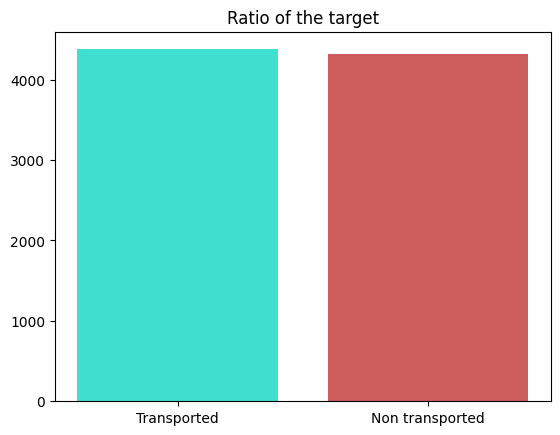

In [8]:
plt.figure()
plt.title('Ratio of the target')
plt.bar(x=['Transported', 'Non transported'],
        height=y_train.value_counts(),
        color=('turquoise', 'indianred')
       )
plt.show()

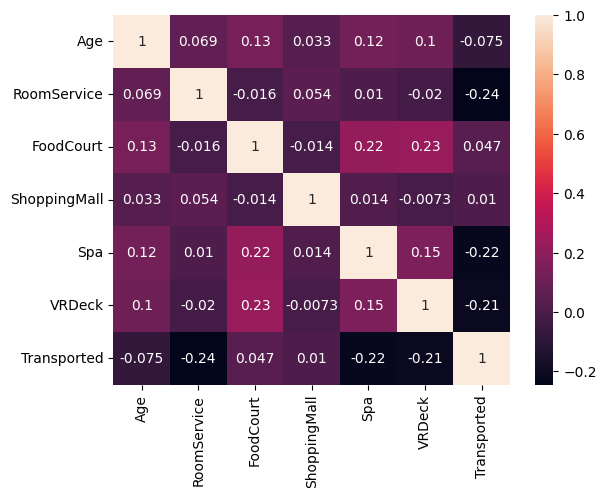

In [9]:
plt.figure()
sns.heatmap(train.corr(), annot=True)
plt.show()

### Features exploration

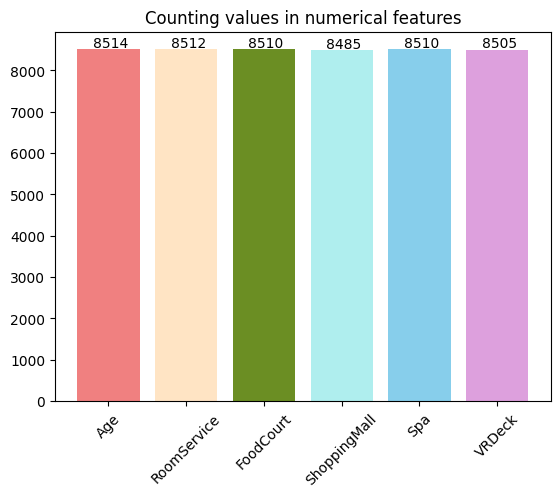

In [10]:
# Declaration of variables

color = ['lightcoral', 'bisque', 'olivedrab',
         'paleturquoise', 'skyblue', 'plum'
        ]
train_num_col = train.select_dtypes('number')
height = [train_num_col[x].count() for x in train_num_col]

# Plotting graphic

plt.bar(x=train_num_col.columns, height=height, color=color, align='center')
plt.xticks(rotation=45)
for num, hei in zip(range(train_num_col.shape[1]), height):
    plt.annotate(hei, (num - 0.2, hei+50))
    
plt.title('Counting values in numerical features')
plt.show()

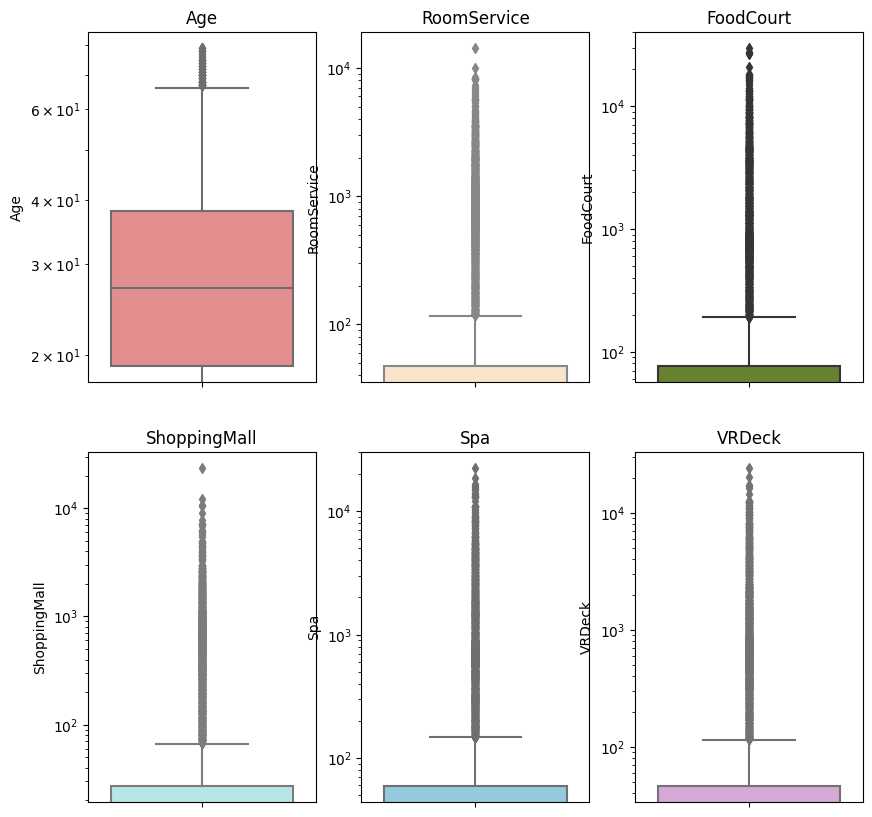

In [11]:
# 3 graphics per column

nb_rows = train_num_col.shape[1] // 3

# Plotting graph

plt.figure(figsize=(10, 10))

# Adding graphics one by one
for i, col in enumerate(train_num_col, start=1):
    plt.subplot(nb_rows, 3, i)
    sns.boxplot(data=train, y=col, color=color[i - 1])
    plt.title(col)
    plt.yscale('log')
plt.show()

In [12]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


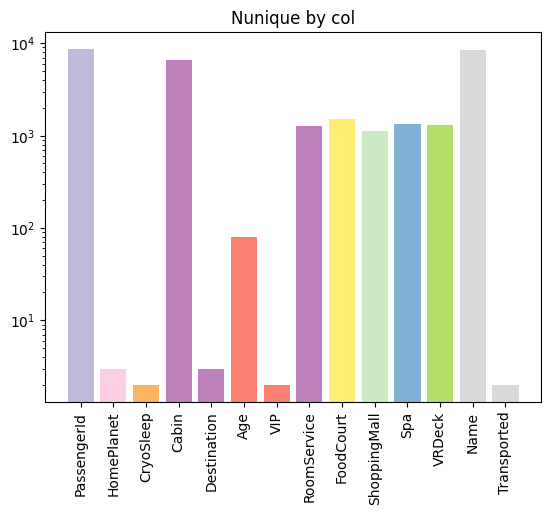

In [14]:
# Declaration of variables

np.random.seed(1234)
cmap = matplotlib.cm.get_cmap('Set3')
color = [cmap(np.random.rand()) for _ in range(train.shape[1])]

# Plotting graphic

plt.bar(train.columns, train.nunique(), color=color)
plt.title('Nunique by col')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

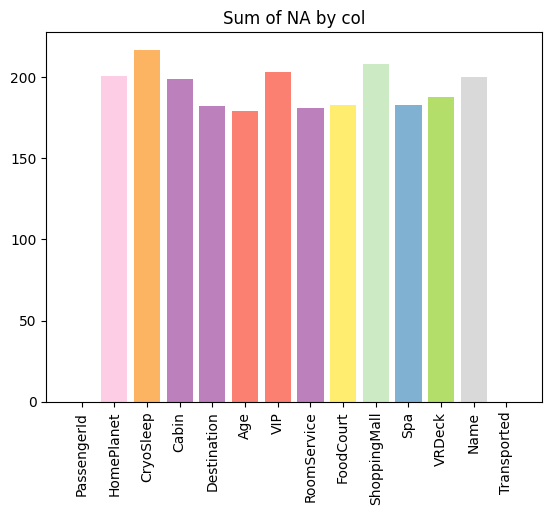

In [15]:
# Plotting graphic

plt.bar(train.columns, train.isnull().sum(), color=color)
plt.title('Sum of NA by col')
plt.xticks(rotation=90)
plt.show()

## 4. Preprocessing/Creation of pipelines

In [16]:
# Add preprocessing pipeline for optimisation

# Division of columns by categories

categorical_features = ['HomePlanet', 'CryoSleep',
                        'Cabin', 'Destination', 'VIP']
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
                      'Spa', 'VRDeck']

# Creation of categorical pipelines

categorial_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                    OneHotEncoder(handle_unknown='ignore')
                                    )
numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean',
                                                 fill_value=0),
                                   StandardScaler())

# Final preprocessor pipeline creation

preprocessor = make_column_transformer(
                                (categorial_pipeline, categorical_features),
                                (numerical_pipeline, numerical_features)
                                )

In [17]:
# Encoding target 

y_train = LabelEncoder().fit_transform(y_train)

## 5. Train et validation set

In [18]:
# Variable slicing for hyperparameter optimization

train_set, val_train_set, test_set, val_test_set = train_test_split(
                                                                x_train,
                                                                y_train,
                                                                test_size=0.25,
                                                                random_state=0
                                                                )

## 6. Model training

In [19]:
# Model creation with the preprocessor pipeline

model = make_pipeline(preprocessor, LogisticRegression(solver='liblinear'))
model.fit(train_set, test_set)

# Baseline definition

score = model.score(val_train_set, val_test_set)

print(f'Our baseline to beat is {score}')

Our baseline to beat is 0.7851885924563018


### Optimisation with GridSearchCV

In [20]:
# Adding PolynomialFeatures to the numerical pipeline

numerical_pipeline = make_pipeline(SimpleImputer(
                                        strategy='mean',
                                        fill_value=0
                                        ),
                                   PolynomialFeatures(),
                                   StandardScaler())

preprocessor = make_column_transformer(
                                (categorial_pipeline, categorical_features),
                                (numerical_pipeline, numerical_features)
                                )

model = make_pipeline(preprocessor, LogisticRegression(solver='liblinear'))

In [21]:
# Creation of the parameter dictionary

param_grid = {
    'columntransformer__pipeline-2__simpleimputer__strategy': ['mean',
                                                               'median',
                                                               'most_frequent'
                                                               ],
    'columntransformer__pipeline-2__polynomialfeatures__degree': [2, 3, 4, 5],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logisticregression__solver': ['newton-cg', 'liblinear'],
    'logisticregression__C': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
    }

grid = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=5)

Uncomment these lines below if you want to 
search for the best parameters with GridSearchCV.

It takes a lot of time to complete

I have already done this and the result of the 
best settings is in a comment below.


In [22]:
#grid.fit(train_set, test_set)
#model = grid.best_estimator_
#grid.best_params_

Best parameters :

{'columntransformer__pipeline-2__polynomialfeatures__degree': 3,
 'columntransformer__pipeline-2__simpleimputer__strategy': 'most_frequent',
 'logisticregression__C': 1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'newton-cg'}

In [64]:
# Definition of the configuration from the best parameters of GridSearchCV

categorial_pipeline = make_pipeline(SimpleImputer(strategy = 'most_frequent'), OneHotEncoder(handle_unknown = 'ignore'))
numerical_pipeline = make_pipeline(SimpleImputer(strategy = 'most_frequent', fill_value=0), PolynomialFeatures(degree=3), StandardScaler())

preprocessor = make_column_transformer(
    (categorial_pipeline, categorical_features),
    (numerical_pipeline, numerical_features)
    )

model = make_pipeline(preprocessor, LogisticRegression(solver='newton-cg'))

In [65]:
# Training and testing the model on our training set

model.fit(train_set, test_set)
model.score(val_train_set, val_test_set)

0.7865685372585096

### 7. Prediction

In [25]:
prediction = model.predict(x_test)

In [26]:
prediction

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [27]:
# processing for submission

data = {'PassengerId': x_test.PassengerId, 'Transported': prediction}
pred_df = pd.DataFrame.from_dict(data)
pred_df['Transported'].replace({0: False, 1:True}, inplace=True)

<AxesSubplot:ylabel='Transported'>

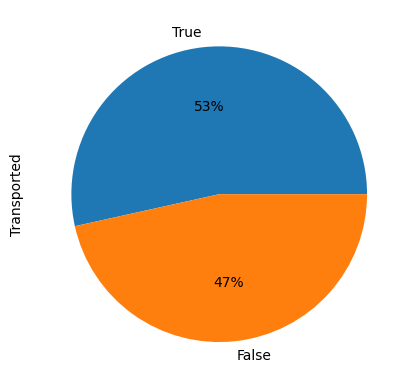

In [28]:
# Analysis of predictions

pred_df.Transported.value_counts().plot(kind='pie', autopct='%.0f%%')

### 8. Submission

In [30]:
pred_df.to_csv('submission.csv', index=False)

### 9. Information of the prediction

In [66]:
y_pred = model.predict(val_train_set)

In [61]:
def plot_score(val, pred):
    cf_matrix = confusion_matrix(val, pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ['{0:.2%}'.format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]


    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.title(f'{model[1]}')
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    print(model[1])
    print(f' accuracy   : {accuracy_score(val_test_set, y_pred)}')
    print(f' precision  : {precision_score(val_test_set, y_pred)}')
    print(f' recall     : {recall_score(val_test_set, y_pred)}')
    print(f' F1         : {f1_score(val_test_set, y_pred)}')

LogisticRegression(solver='newton-cg')
 accuracy   : 0.7865685372585096
 precision  : 0.772609819121447
 recall     : 0.8176845943482224
 F1         : 0.7945084145261293


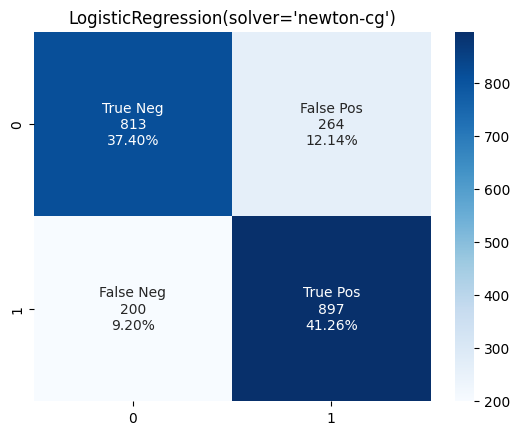

In [67]:
plot_score(val_test_set, y_pred)

K-nearest neighbours

KNeighborsClassifier(algorithm='brute', n_jobs=-1)
 accuracy   : 0.7736890524379025
 precision  : 0.7651183172655566
 recall     : 0.7958067456700091
 F1         : 0.7801608579088471


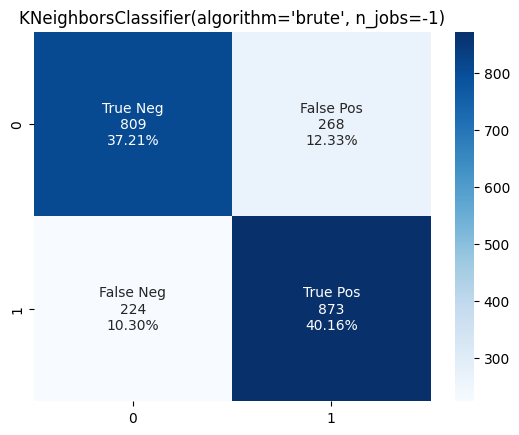

In [57]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)

model = make_pipeline(preprocessor, knn)
model.fit(train_set, test_set)
y_pred = model.predict(val_train_set)

plot_score(val_test_set, y_pred)

LinearSVC(C=0.0001)
 accuracy   : 0.7833486660533578
 precision  : 0.7887453874538746
 recall     : 0.7793983591613491
 F1         : 0.7840440165061898


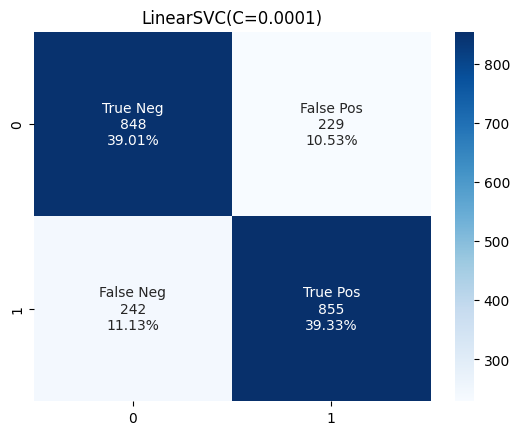

In [58]:
from sklearn.svm import LinearSVC
svm=LinearSVC(C=0.0001)

model = make_pipeline(preprocessor, svm)
model.fit(train_set, test_set)
y_pred = model.predict(val_train_set)

plot_score(val_test_set, y_pred)

DecisionTreeClassifier()
 accuracy   : 0.7552897884084636
 precision  : 0.7437446074201898
 recall     : 0.7857793983591613
 F1         : 0.7641843971631205


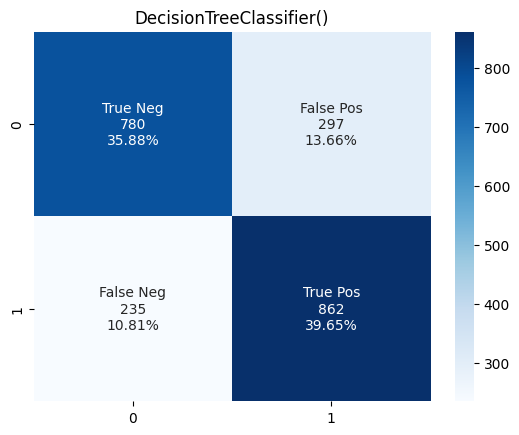

In [59]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

model = make_pipeline(preprocessor, clf)
model.fit(train_set, test_set)
y_pred = model.predict(val_train_set)

plot_score(val_test_set, y_pred)